# COSMOS WCS

In [1]:
%pylab inline
from astropy.io import fits
from astropy import wcs
import numpy as np
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
cc = {'cmap':'inferno', 'vmin':-.01, 'vmax':0.1}

In [4]:
dlp_filename = 'dlp_samples.fits'
dlp_samples = fits.getdata(dlp_filename).astype('float32')
dlp_samples.shape

(400, 360, 360)

In [5]:
dlp_mean = dlp_samples.mean(axis=0)

In [6]:
from astropy.wcs import WCS

# create a fits map
res = 0.29/60

wcs_helix_list = WCS(naxis=2)
wcs_helix_list.wcs.crpix = [360//2, 360//2] # reference pixel point
wcs_helix_list.wcs.crval = [150.11, 2.24] # reference coordinates
wcs_helix_list.wcs.cunit = ["deg", "deg"]
wcs_helix_list.wcs.ctype = ["RA---TAN", "DEC--TAN"]
wcs_helix_list.wcs.cdelt = [res, res]
wcs_helix_list.array_shape = [360, 360]
wcs_helix_list
w_dlp = wcs_helix_list

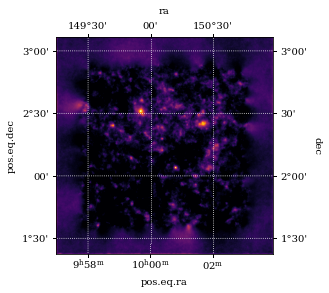

In [7]:
vmin = -.01
vmax = 0.1
kwargs = dict(cmap='inferno', vmin=vmin, vmax=vmax)

fig = figure()
ax = fig.add_subplot(111, projection=w_dlp)
ax.imshow(dlp_mean, aspect='equal', **kwargs)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

In [8]:
data = dlp_mean
header = w_dlp.to_header()
hdu = fits.PrimaryHDU(data=data, header=header)

In [9]:
w_dlp

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 150.11  2.24  
CRPIX : 180.0  180.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.004833333333333333  0.004833333333333333  
NAXIS : 360  360

## Massey COSMOS map

In [10]:
with fits.open('cosmos_e.fits') as hdul:
    hdul.info()
    w_massey = wcs.WCS(hdul[0].header)
massey = fits.getdata('cosmos_e.fits')
w_massey

Filename: cosmos_e.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (492, 477)   float32   


 [astropy.io.fits.verify]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 150.796  1.5696  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.00277778  0.00277778  
NAXIS : 492  477

(-0.5, 491.5)


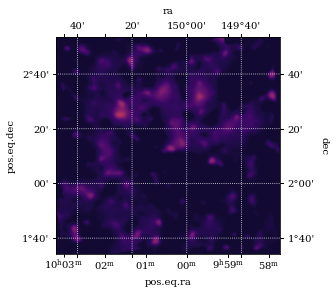

In [11]:
fig = figure()
ax = fig.add_subplot(111, projection=w_massey)
ax.imshow(massey, aspect='equal', **kwargs)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
print(ax.get_xlim())

## Interpolate Massey map into DLP reference frame

Using `scipy.interpolate.interp2d`

In [12]:
from scipy import interpolate

In [13]:
x = np.arange(massey.shape[1])
y = np.arange(massey.shape[1])
massey_wm = w_massey.pixel_to_world(x, y) # works if we assume regular grid
masse_dlpx, masse_dlpy = w_dlp.world_to_pixel(massey_wm)
f = interpolate.interp2d(masse_dlpy, masse_dlpx[:477], massey)

In [14]:
xp = np.arange(360)
yp = np.arange(360)
massey_new = f(xp, yp)

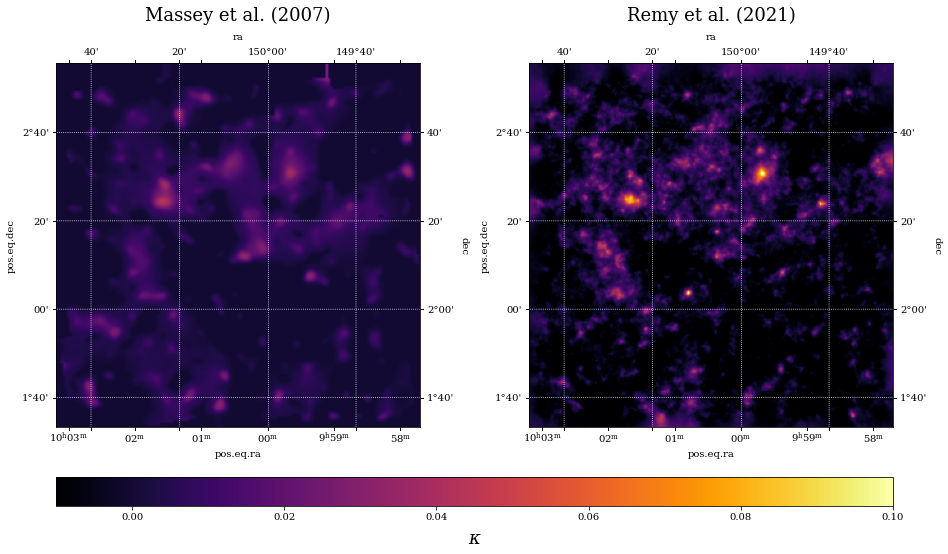

In [15]:
width = 360
resolution = 0.29

vmin = -.01
vmax = 0.1

# plot within survey mask
xmin = 321.5
xmax = 37.5
ymin = 37.5
ymax = 321.5

font = dict(fontsize=18)
kwargs = dict(cmap='inferno', vmin=vmin, vmax=vmax)

fig = plt.figure(figsize=(15,8))

ax0 = fig.add_subplot(121, projection=w_dlp)
im = ax0.imshow(massey_new[::-1,::-1], aspect='equal', **kwargs)
ax0.set_title('Massey et al. (2007)', y=1.1, **font)
ax0.invert_xaxis()
ax0.set_xlim([xmin, xmax])
ax0.set_ylim([ymin, ymax])
overlay = ax0.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')


ax1 = fig.add_subplot(122, projection=w_dlp)
im = ax1.imshow(dlp_mean, origin='lower', aspect='equal', **kwargs)
ax1.invert_xaxis()
ax1.set_xlim([xmin, xmax])
ax1.set_ylim([ymin, ymax])
ax1.set_title('Remy et al. (2021)', y=1.1, **font)
overlay = ax1.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax0p = ax0.get_position()
ax1p = ax1.get_position()

fig.subplots_adjust(wspace=0.3)

cbar_ax = fig.add_axes([ax0p.x0, 0.05, ax1p.x1-ax0p.x0, 0.05])
cb = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar_ax.set_title(r'$\kappa$', y=-1.5, **font)
#cb.ax.tick_params(labelsize=18)
savefig('cosmos_mass_maps.pdf', bbox_inches='tight')